## Denoising Diffusion Probabilistic Models (DDPM) サンプルコード
このコードは授業用に用意したDDPMの簡易実装版です。オリジナルの論文の実装とは異なります。<br>
必要な部分を追記することで、[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)と呼ばれる衣服の白黒画像データセットを対象に、学習および生成ができます。<br>
(コードを少し書き換えることで他の[データセット](https://pytorch.org/vision/stable/datasets.html)でも学習可能です。）<br>

CPUでも実行自体は可能ですが、実用的な時間での計算は恐らく困難ですので、GPUを使うことを推奨します。<br>
Googleのアカウントを作れば、誰でも無料で[Colaboratory](https://colab.research.google.com/?hl=ja)でGPUを使うことができます。<br>
Colaboratoryにこのノートブックをアップロードして、GPUのランタイムに接続することで実行できます。基本的な使い方はJupyter Notebookと同じです。<br>

コードは7つのStepで構成されています：

0. 準備：ライブラリのインポートやパラメータの定義など<br>
1. データセット読み込み
2. DDPMの定義：前半はSelf-AttentionなどUNetモデルを構成するためのモジュールが定義されています。この授業では必ずしも理解の必要はありません。
3. 損失関数の定義
4. DDPMの学習
5. ランダムノイズからの画像生成
6. FIDによる定量評価

### 課題
1. Step3について3～5行目のコメントを参考に損失関数を完成させて実行結果を確認しなさい。（仮の値を変数に代入しているので書き直すこと。）<br>
2. 拡散過程の総ステップ数が定量評価指標に与える影響を実験・考察しなさい。
3. ある実画像をx0としたとき、拡散過程でノイズ画像 xt (t<総ステップ数)を生成し、逆拡散過程で xt をデノイズすると、VAEのように元の画像は復元できるだろうか？ t の大小がデノイズ結果に与える影響を実験・考察しなさい。

レポートのファイル名やフォーマットは自由。ただし学籍番号、氏名、プログラムのソースコード、実行結果を含め、各課題の回答がわかるように記載し、一つのPDFファイルにして提出すること。

###    Step 0. 準備

In [1]:
!pip install torch torchvision
!pip install torchmetrics torch-fidelity

In [2]:
#ライブラリのインポート
import numpy as np
import math
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST, CIFAR10
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [3]:
#パラメータの設定
dataset_path = './data' #読み込んだデータセットを保存しておくパス
cuda = True #GPUを使う場合はTrueにする
device = torch.device("cuda" if cuda else "cpu")

diffusion_steps = 500 #拡散過程の総ステップ数

batch_size = 100 #学習時に一回のパラメータ更新で使う訓練画像の枚数
lr = 1e-3 #学習率(ネットワークの重みパラメータの更新幅)
epochs = 5 #学習回数(全訓練データをモデルに何周学習させるか)

###    Step 1. データセットの読み込み

In [4]:
#Fashion-MNISTの読み込み
img_size = 32 #画像幅
channel_num = 1 #チャネル数(グレースケールなので1)
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]), #画素値を-1～1の範囲に正規化
        transforms.Resize(img_size, antialias=True) #UNetで扱うために画像幅を2のべき乗にリサイズ
])
train_dataset = FashionMNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = FashionMNIST(dataset_path, transform=mnist_transform, train=False, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

# #CIFAR10の読み込み（こちらを使う場合は上のFashion-MNISTをコメントアウト）
# img_size = 32
# channel_num = 3
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])
# train_dataset = CIFAR10(dataset_path, transform=transform, train=True, download=True
# test_dataset = CIFAR10(dataset_path, transform=transform, train=False, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:21<00:00, 1233248.36it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 114297.56it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1129616.24it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5851565.58it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Step 2. DDPMの定義

In [5]:
#DDPMで用いるニューラルネットの各モジュールを定義（今回は詳しい理解は不要）
class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value


class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
#拡散モデルを定義
class DiffusionModel(nn.Module):
    def __init__(self, in_size, t_range, img_depth, device='cpu'):
        super().__init__()
        self.t_range = t_range
        self.in_size = in_size
        self.device=device
        
        #ノイズスケジュールパラメータの定義
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.betas = torch.from_numpy(np.array(
            [self.beta_small + (t / self.t_range) * (self.beta_large - self.beta_small) for t in range(self.t_range)]
        ).astype(np.float32)).to(device)
        self.alphas = 1-self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
        #各層の定義
        bilinear = True
        self.inc = DoubleConv(img_depth, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, img_depth)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)      
    
    #時刻情報を正弦波位置埋め込みの特徴量に変換する関数
    def pos_encoding(self, t, channels, embed_size):
        t = t.unsqueeze(-1) if t.dim()==1 else t
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)
    
    #UNetの順伝播処理：引数xに付与されたノイズepsilonを推定
    def forward(self, x, t):
        #時刻情報を反映するために各層の特徴マップの各画素に時刻特徴量を加算
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, int(x1.shape[-1]/2))
        x3 = self.down2(x2) + self.pos_encoding(t, 256, int(x2.shape[-1]/2))
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, int(x3.shape[-1]/2))
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, int(x4.shape[-1]*2))
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, int(x.shape[-1]*2))
        x = self.up3(x, x1) + self.pos_encoding(t, 64, int(x.shape[-1]*2))
        output = self.outc(x)
        return output
    
    #拡散過程の定義：引数xに時刻tのノイズを付与した画像xt、および付与したノイズepsilonを返す
    def forward_diffusion(self, x, t):
        epsilon = torch.randn(x.shape, device=self.device)
        alpha_bars = self.alpha_bars[t].reshape((-1, 1, 1, 1))
        xt = torch.sqrt(alpha_bars)*x+torch.sqrt(1-alpha_bars)*epsilon
        return xt, epsilon
    
    #逆拡散過程の定義：時刻tにおける引数xに対してt-1のデノイズ結果を返す
    def reverse_diffusion(self, x, t):
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape, device=self.device)
            else:
                z = 0

            e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1))
            pre_scale = 1 / math.sqrt(self.alphas[t])
            e_scale = (1 - self.alphas[t]) / math.sqrt(1 - self.alpha_bars[t])
            post_sigma = math.sqrt(self.betas[t]) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

model = DiffusionModel(img_size*img_size, diffusion_steps, channel_num, device=device).to(device)

### Step 3. 損失関数の定義
#### 課題のヒント
- 損失関数の引数の説明
    - x0：時刻 t=0 の画像のテンソル

- 課題で使うことを想定した演算・関数
    - テンソルどうしは + や - で加算減算が可能
    - Step2のDiffusionModelクラスのメンバ関数（コメントを参照）
    - (テンソル)**2：テンソルの各要素を二乗する
    - (テンソル).sum()：テンソルの各要素の和をとる

In [7]:
def loss_function(x0):
    t = torch.randint(0, diffusion_steps, [x0.shape[0]], device=device) #時刻tを一様分布からサンプリング
    xt, epsilon =  model.forward_diffusion(x0, t) #拡散過程によりノイズ画像xtとノイズepsilonを取得
    epsilon_pred = model.forward(xt,t) #UNetの順伝播によりxtに付与されたノイズepsilon_predを推定
    loss = torch.mean((epsilon - epsilon_pred) ** 2) #epsilonとepsilon_predの誤差を損失lossとして計算
    return loss

### Step 4. DDPMの学習

In [8]:
!pip install ipywidgets


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train()
print("Start training DDPM...")
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x,_) in tqdm(enumerate(train_loader), total=len(train_loader)):#画像をbatch_size枚ずつ読み込みxに格納
        #x = x.view(batch_size, x_dim)#(batch_size,縦幅,横幅)のテンソルを(batch_size,縦幅x横幅)のテンソルに変換
        x = x.to(device)#GPUで処理する場合はデータをGPUに移動、CPUの場合はそのままz
        optimizer.zero_grad()#最適化器を初期化
        loss = loss_function(x)#損失関数を計算
        overall_loss += loss.item()#損失の総和を計算
        loss.backward()#誤差伝播法によりネットワークの重みパラメータに対する勾配を計算
        optimizer.step()#重みパラメータの更新
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training DDPM...


  0%|          | 0/600 [00:00<?, ?it/s]

	Epoch 1 complete! 	Average Loss:  0.0014601705545475567


  0%|          | 0/600 [00:00<?, ?it/s]

	Epoch 2 complete! 	Average Loss:  0.0006169572262363959


  0%|          | 0/600 [00:00<?, ?it/s]

	Epoch 3 complete! 	Average Loss:  0.0005709904466502257


  0%|          | 0/600 [00:00<?, ?it/s]

	Epoch 4 complete! 	Average Loss:  0.0005376094303564953


  0%|          | 0/600 [00:00<?, ?it/s]

	Epoch 5 complete! 	Average Loss:  0.000505653233244045
Finish!!


### Step 5. ランダムノイズからの画像生成

  0%|          | 0/499 [00:00<?, ?it/s]

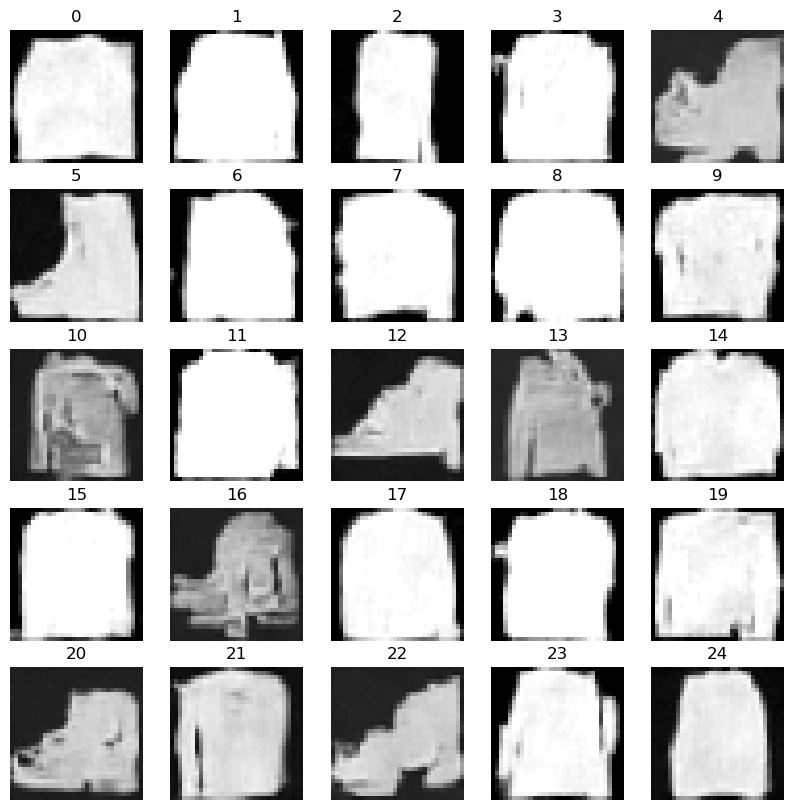

In [10]:
import matplotlib.pyplot as plt
def show_images(x, n_row=5, n_col=5):
    x = x.repeat((1,3,1,1)) if x.shape[1]==1 else x #白黒画像(1チャネル)なら可視化用にRGB画像(3チャネル)に変換
    x = x.moveaxis(1, 3)
    plt.figure(figsize=(10, 10))
    for i in range(n_row*n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.title(i)
        plt.imshow(x[i].cpu().numpy())
        plt.axis('off')

xt = torch.randn((25, channel_num, img_size, img_size)).to(device)
sample_steps = torch.arange(diffusion_steps-1, 0, -1).to(device)
for t in tqdm(sample_steps):
    xt = model.reverse_diffusion(xt, t)
xt = (xt.clamp(-1, 1) + 1)/2
show_images(xt)

### Step6. FIDによる定量評価

In [11]:
gt = [] #正解画像(ground truth)リスト
for test_img, _ in test_loader:
    gt.append((test_img.to(device)+1)/2.)
gt = torch.cat(gt, dim=0)
gt = gt[:xt.shape[0]] #VRAMの消費を減らすためにデータ数をxtに揃える(全データを使って評価しても良い)

xt = xt.repeat((1,3,1,1)) if xt.shape[1]==1 else xt #白黒画像(1チャネル)なら評価用にRGB画像(3チャネル)に変換
gt = gt.repeat(1,3,1,1) if gt.shape[1]==1 else gt #白黒画像(1チャネル)なら評価用にRGB画像(3チャネル)に変換

fid = FrechetInceptionDistance(feature=64, normalize=True).to(device)
fid.update(gt, real=True)
fid.update(xt, real=False)
fid.compute()

tensor(17.9754, device='cuda:0')

## 課題2

In [12]:
import torch
from tqdm import tqdm
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt

# 設定
diffusion_steps_list = [100, 200, 500, 1000, 2000]
results = []

# 学習と評価
for diffusion_steps in diffusion_steps_list:
    print(f"Training DDPM with {diffusion_steps} diffusion steps...")
    model = DiffusionModel(img_size * img_size, diffusion_steps, channel_num, device=device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
            x = x.to(device)
            optimizer.zero_grad()
            loss = loss_function(x)
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"\tEpoch {epoch + 1} complete! \tAverage Loss: {overall_loss / (batch_idx * batch_size)}")

    print("Training complete. Starting evaluation...")

    # サンプリング
    xt = torch.randn((25, channel_num, img_size, img_size)).to(device)
    sample_steps = torch.arange(diffusion_steps - 1, 0, -1).to(device)
    for t in tqdm(sample_steps):
        xt = model.reverse_diffusion(xt, t)
    xt = (xt.clamp(-1, 1) + 1) / 2

    # 正解画像取得
    gt = []
    for test_img, _ in test_loader:
        gt.append((test_img.to(device) + 1) / 2.)
    gt = torch.cat(gt, dim=0)
    gt = gt[:xt.shape[0]]

    xt = xt.repeat((1, 3, 1, 1)) if xt.shape[1] == 1 else xt
    gt = gt.repeat(1, 3, 1, 1) if gt.shape[1] == 1 else gt

    # FID計算
    fid = FrechetInceptionDistance(feature=64, normalize=True).to(device)
    fid.update(gt, real=True)
    fid.update(xt, real=False)
    fid_score = fid.compute().item()
    results.append({"diffusion_steps": diffusion_steps, "FID": fid_score})
    print(f"Diffusion Steps: {diffusion_steps}, FID: {fid_score}")


Training DDPM with 100 diffusion steps...


 62%|██████▏   | 370/600 [00:23<00:14, 15.64it/s]


KeyboardInterrupt: 

## 課題3

In [13]:
diffusion_steps = 1000
epochs = 5
model = DiffusionModel(img_size*img_size, diffusion_steps, channel_num, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train()
print("Start training DDPM...")
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x,_) in tqdm(enumerate(train_loader), total=len(train_loader)):#画像をbatch_size枚ずつ読み込みxに格納
        #x = x.view(batch_size, x_dim)#(batch_size,縦幅,横幅)のテンソルを(batch_size,縦幅x横幅)のテンソルに変換
        x = x.to(device)#GPUで処理する場合はデータをGPUに移動、CPUの場合はそのままz
        optimizer.zero_grad()#最適化器を初期化
        loss = loss_function(x)#損失関数を計算
        overall_loss += loss.item()#損失の総和を計算
        loss.backward()#誤差伝播法によりネットワークの重みパラメータに対する勾配を計算
        optimizer.step()#重みパラメータの更新
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training DDPM...


100%|██████████| 600/600 [00:38<00:00, 15.65it/s]


	Epoch 1 complete! 	Average Loss:  0.0011354151829915473


100%|██████████| 600/600 [00:38<00:00, 15.73it/s]


	Epoch 2 complete! 	Average Loss:  0.0004595826607887852


100%|██████████| 600/600 [00:38<00:00, 15.70it/s]


	Epoch 3 complete! 	Average Loss:  0.0004209374223146992


100%|██████████| 600/600 [00:38<00:00, 15.75it/s]


	Epoch 4 complete! 	Average Loss:  0.00039359361536564535


100%|██████████| 600/600 [00:38<00:00, 15.72it/s]

	Epoch 5 complete! 	Average Loss:  0.0003727396952613367
Finish!!


torch.Size([100, 1, 32, 32])
     t       MSE
0   10  0.625201
1   50  0.630953
2  100  0.638669
3  200  0.653076
4  500  0.731501


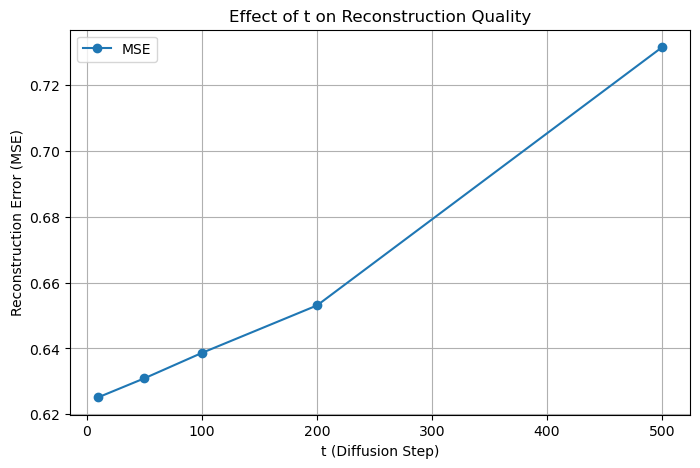

In [18]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

# 設定
t_values = [10, 50, 100, 200, 500]  # t の値
results = []

import torch
import pandas as pd

# 設定
t_values = [10, 50, 100, 200, 500]  # t の値


def evaluate_quality(x0, model, t_values):
    """
    拡散過程と逆拡散過程を通じて画像の品質を評価

    Args:
        x0: 元画像 (N, C, H, W)
        model: Diffusion モデル
        t_values: t のリスト

    Returns:
        reconstruction_scores: t ごとの復元スコアリスト (t, MSE)
    """
    reconstruction_scores = []
    for t in t_values:
        # 拡散過程でノイズ画像 xt を生成
        xt, epsilon = model.forward_diffusion(x0, torch.tensor([t]).to(x0.device))

        # 逆拡散過程で xt をデノイズ
        x_rec = xt.clone()
        for step in reversed(range(1, t + 1)):
            x_rec = model.reverse_diffusion(x_rec, torch.tensor([step]).to(x0.device))

        x_rec = (x_rec.clamp(-1, 1) + 1) / 2  # [0, 1] に正規化

        # 復元スコア計算 (MSE)
        mse_score = torch.mean((x0 - x_rec) ** 2).item()
        reconstruction_scores.append((t, mse_score))

    return reconstruction_scores


# テスト用データ (最初のバッチを取得)
for x0, _ in test_loader:
    x0 = x0.to(device)
    break
print(x0.shape)

# 復元スコアと画像を計算
reconstruction_results = evaluate_quality(x0, model, t_values)

# 結果を表形式で表示
reconstruction_df = pd.DataFrame(reconstruction_results, columns=["t", "MSE"])
print(reconstruction_df)

# グラフ化
t_values, mse_scores = zip(*reconstruction_results)
plt.figure(figsize=(8, 5))
plt.plot(t_values, mse_scores, marker="o", label="MSE")
plt.xlabel("t (Diffusion Step)")
plt.ylabel("Reconstruction Error (MSE)")
plt.title("Effect of t on Reconstruction Quality")
plt.grid(True)
plt.legend()
plt.show()

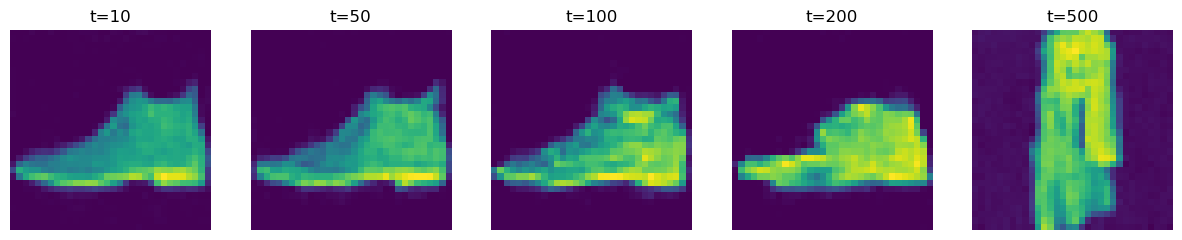

In [26]:
# 指定した時間ステップ
t_values = [10, 50, 100, 200, 500]

# テストデータローダーから元画像 x0 を取得
for x0, _ in test_loader:
    x0 = x0[:1].to(device)  # 最初の1枚を取得
    break

# 拡散過程でノイズ画像 xt を生成
xt_list = []
for t in t_values:
    xt, _ = model.forward_diffusion(x0, torch.tensor(t - 1, device=device))  # t - 1 に修正
    xt_list.append(xt)

# 逆拡散過程で復元
reconstructed_images = []
for xt, t in zip(xt_list, t_values):
    x_rec = xt.clone()
    for step in reversed(range(1, t + 1)):
        x_rec = model.reverse_diffusion(x_rec, torch.tensor([step], device=device))
    x_rec = (x_rec.clamp(-1, 1) + 1) / 2  # 正規化
    reconstructed_images.append(x_rec)

# 結果の表示
def show_images(images, titles, n_row=1, n_col=5):
    plt.figure(figsize=(15, 5))
    for idx, (img, title) in enumerate(zip(images, titles)):
        img = img[0].permute(1, 2, 0).cpu().numpy()  # バッチの1枚目を取得
        plt.subplot(n_row, n_col, idx + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

show_images(reconstructed_images, [f"t={t}" for t in t_values])
